In [2]:
import SchematicTools
from schematic import SchematicFile
import numpy as np
import SchematicTools
from PIL import Image
#import glob


## Take a large schematic (or multiple schematics) as input data.
## Process and export a numpy array that contains a large number of cube-shaped samples. 
## The samples are also processed and converted to a simplified block format. 

## voxel size in width, height, and length.
SAMPLESIZE = 8
## export data path
FILEPATH = '/Users/ikros/Downloads/Minecraft-GAN-City-Generator-master/data/np_samples_%dx.npy' % SAMPLESIZE 
## Input schematic files.
WORLDS = ['/Users/ikros/Downloads/Minecraft-GAN-City-Generator-master/data/zearth_64_144_32.schematic']
## Or you could load a number of schematics from a folder.
#WORLDS = glob.glob("C:/yourschematicfolder/" + '/*.schematic') 
## Number of samples to export.
SAMPLECOUNT = 100000

def sample(area:np.ndarray, samples:int, size:int) :
    samplerY = np.random.randint(0, area.shape[0] - size, samples)
    samplerZ = np.random.randint(0, area.shape[1] - size, samples) 
    samplerX = np.random.randint(0, area.shape[2] - size, samples)
    sampler = np.stack((samplerY, samplerZ, samplerX), axis=-1)
    slices = np.empty((samples, size, size, size), dtype=int)
    for i in range(samples) :
        slices[i] = area[
            sampler[i,0]:sampler[i,0]+size, 
            sampler[i,1]:sampler[i,1]+size, 
            sampler[i,2]:sampler[i,2]+size]
    print("sampled %s" % str(slices.shape))
    return slices

def sampleFlat(area:np.ndarray, samples:int, size:int) :
    print("sampling flat %d, size %d" % (samples, size))
    samplerY = np.random.randint(0, area.shape[0], samples)
    samplerZ = np.random.randint(0, area.shape[1] - size, samples) 
    samplerX = np.random.randint(0, area.shape[2] - size, samples)
    sampler = np.stack((samplerY, samplerZ, samplerX), axis=-1)
    slices = np.empty((samples, size, size), dtype=int)
    for i in range(samples) :
        slices[i] = area[
            sampler[i,0], 
            sampler[i,1]:sampler[i,1]+size, 
            sampler[i,2]:sampler[i,2]+size]
    return slices

def filter(slices:np.ndarray, minFill, maxFill) :
    minBlocks = minFill * SAMPLESIZE**3
    maxBlocks = maxFill * SAMPLESIZE**3
    mask = np.logical_and(slices.sum(axis=(1,2,3)) > minBlocks, slices.sum(axis=(1,2,3)) < maxBlocks) 
    return slices[mask]

def filterFlat(slices:np.ndarray, threshold) :
    mask = slices.sum(axis=(1,2)) > threshold
    return slices[mask]

def showSamples(samples, width, height) :
    preview = np.empty((0, SAMPLESIZE * width,3), np.uint8)
    for i in range(width):
        row = np.empty((SAMPLESIZE, 0, 3), np.uint8)
        for j in range(height):
            imageR = samples[i*width + j, :, :, :] * 255
            imageG = np.average(imageR, axis=0)
            image = np.stack((imageR[0], imageG, imageG), axis=2)
            row = np.hstack((row, image))
        preview = np.vstack((preview, row))

    outputimage = Image.fromarray(preview.astype(np.uint8))
    #outputimage.save('samplesPreview.png')
    outputimage.show()

def exportSamples(samples, width, height, spacing) :
    exportWorld = np.empty((SAMPLESIZE, (SAMPLESIZE + spacing) * width, 0), np.uint8)
    for i in range(width):
        row = np.empty((SAMPLESIZE, 0, SAMPLESIZE), np.uint8)
        for j in range(height):
            structure = samples[i*width + j, :, :, :] # load a sample
            #apply spacing
            structure = np.concatenate((structure, np.zeros((SAMPLESIZE, spacing, SAMPLESIZE), dtype=np.uint8)), axis=1)
            #add to the row
            row = np.concatenate((row, structure), axis=1)
        #add to the column
        exportWorld = np.concatenate((exportWorld, row), axis=2)
        #apply spacing
        exportWorld = np.concatenate((exportWorld, np.zeros((SAMPLESIZE, (SAMPLESIZE + spacing) * width, spacing), dtype=np.uint8)), axis=2)
    exportSchematic = SchematicFile(shape=exportWorld.shape)
    exportSchematic.blocks = exportWorld
    exportSchematic.save("/Users/ikros/Downloads/Minecraft-GAN-City-Generator-master/data/sampledExample.schematic")

In [29]:
simpleWorlds = []
for w in WORLDS :
    simpleWorlds.append(SchematicTools.simplify(SchematicTools.loadArea(w)))
print("loaded %d worlds" % len(simpleWorlds))
samples = np.empty((0, SAMPLESIZE, SAMPLESIZE, SAMPLESIZE))
for s in simpleWorlds :
    samples = np.concatenate((samples, sample(s, SAMPLECOUNT, SAMPLESIZE)), axis=0)
#sampleWorld = SchematicTools.loadArea('data/sample_world.schematic')
#simplifiedWorld = SchematicTools.simplify(sampleWorld)
#print("loaded area: %d, %d, %d" % simplifiedWorld.shape)
#testSamples = sample(simplifiedWorld, SAMPLECOUNT, SAMPLESIZE)
print("sampled total %s" % str(samples.shape))
filtered = filter(samples, .05, .7)
print("filtered to %s" % str(filtered.shape))
#np.save(FILEPATH, filtered)
print("saved to: %s" % FILEPATH)
showSamples(filtered, 10, 10)
#exportSamples(filtered, 16, 16, 2)

loaded 1 worlds
sampled (100000, 8, 8, 8)
sampled total (100000, 8, 8, 8)
filtered to (52259, 8, 8, 8)
saved to: /Users/ikros/Downloads/Minecraft-GAN-City-Generator-master/data/np_samples_8x.npy


In [30]:
simpleWorlds[0].shape

(32, 144, 64)

In [31]:
samples.shape

(100000, 8, 8, 8)

In [33]:
filtered.shape

(52259, 8, 8, 8)

In [37]:
simpleWorlds = SchematicTools.loadArea(w)
print(simpleWorlds)

[[[  1   1   1 ...   0   0   0]
  [  1   1   1 ...   0   0   0]
  [  1   1   3 ...   0   0   0]
  ...
  [ 98  98  98 ...   1   1   1]
  [  3   3   3 ...   1   1   1]
  [  3   3   3 ...   1   1   1]]

 [[  1   1   3 ...   0   0   0]
  [  3   3   3 ...   0   0   0]
  [  3   3   3 ...   0   0   0]
  ...
  [159  98   3 ...   1   1   1]
  [  4  98   4 ...   1   1   1]
  [  4  43   4 ...   1   1   1]]

 [[  3   3   3 ...   0   0   0]
  [  3   3   3 ...   0   0   0]
  [  3   3   3 ...   0   0   0]
  ...
  [  5  98  98 ...   1   1   1]
  [130   5   0 ...   1   1   1]
  [  0  64   0 ...   1   1   1]]

 ...

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0  

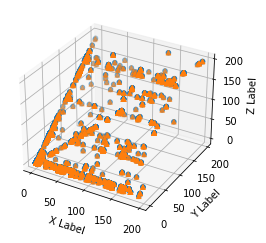

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    #xs = randrange(n, 23, 32)
    #ys = randrange(n, 0, 100)
    #zs = randrange(n, zlow, zhigh)
    ax.scatter(simpleWorlds[2], simpleWorlds[1], simpleWorlds[1], marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()